# Risque de cancer du col de l'utérus

In [1]:
import numpy as np, pandas as pd, seaborn as sns  
from datetime import datetime as dt
import os, warnings, time
from matplotlib import pyplot as plt

if int(str(sns.__version__).split('.')[1]) > 8 : 
    plt.style.use('seaborn-v0_8-darkgrid')
else:
    plt.style.use('seaborn-darkgrid')
    
sns.set(font_scale=2)
warnings.filterwarnings(action="ignore")
seed = 123456789

# Librairies du projet

In [2]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import NuSVC, SVC, OneClassSVM
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, RationalQuadratic, ExpSineSquared, DotProduct, Matern, WhiteKernel

from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB
# from lightgbm import LGBMClassifier
# from xgboost  import XGBClassifier
from sklearn.metrics import roc_curve, auc

from sklearn.metrics  import make_scorer, confusion_matrix, roc_curve, auc, accuracy_score, log_loss, hamming_loss, \
                             precision_score, recall_score, f1_score, jaccard_score,  \
                             precision_recall_curve, average_precision_score

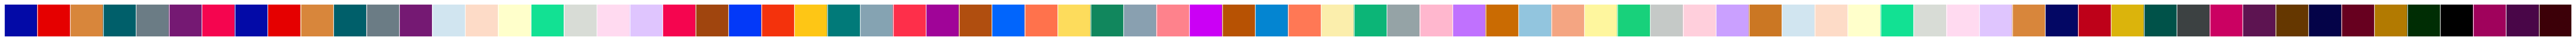

In [3]:
palette = [ "#030aa7", "#e50000", "#d8863b", "#005f6a", "#6b7c85", "#751973",
            "#f5054f", 
            "#030aa7", "#e50000", "#d8863b", "#005f6a", "#6b7c85", "#751973", "#d1e5f0", "#fddbc7",
            "#ffffcb", "#12e193", "#d8dcd6", "#ffdaf0", "#dfc5fe", "#f5054f", "#a0450e",
            "#0339f8", "#f4320c", "#fec615", "#017a79", "#85a3b2", "#fe2f4a", "#a00498", "#b04e0f",
            "#0165fc", "#ff724c", "#fddc5c", "#11875d", "#89a0b0", "#fe828c", "#cb00f5", "#b75203",
            "#0485d1", "#ff7855", "#fbeeac", "#0cb577", "#95a3a6", "#ffb7ce", "#c071fe", "#ca6b02",
            "#92c5de", "#f4a582", "#fef69e", "#18d17b", "#c5c9c7", "#ffcfdc", "#caa0ff", "#cb7723",
            "#d1e5f0", "#fddbc7", "#ffffcb", "#12e193", "#d8dcd6", "#ffdaf0", "#dfc5fe", "#d8863b",
            "#030764", "#be0119", "#dbb40c", "#005249", "#3c4142", "#cb0162", "#5d1451", "#653700",
            "#040348", "#67001f", "#b27a01", "#002d04", "#000000", "#a0025c", "#490648", "#3c0008"
          ]

paletteA = ['#b2182b','#008827','#053061','#ffa500', '#34495e', '#e74c3c', 
          '#9b59b6', '#0165fc','#2ecc71', '#cb7723', '#89a0b0']

sns.palplot(sns.color_palette(palette))

In [4]:
repertoireRacine  = '.'
nomProjet         = "Breast Cancer Wisconsin"

repertoireProjet  = os.path.join(repertoireRacine, nomProjet)
repertoireDonnees = os.path.join(repertoireProjet, 'repertoire.donnees')
repertoireImages  = os.path.join(repertoireProjet, 'repertoire.images')


def controleExistenceRepertoire( repertoire, create_if_needed=True):
    """Voir si le répertoire existe. S'il n'existe pas il est créé."""
    path_exists = os.path.exists(repertoire)
    if path_exists:
        if not os.path.isdir(repertoire):
            raise Exception("Trouvé le nom  "+repertoire +" mais c'est un fichier, pas un répertoire")
            # return False
        return True
    if create_if_needed:
        os.makedirs(repertoire)

def sauvegarderImage( fichier):
    """Enregistrez la figure. Appelez la méthode juste avant plt.show ()."""
    controleExistenceRepertoire(repertoireImages)
    plt.savefig(os.path.join(repertoireImages,
                             fichier+f"--{dt.now().strftime('%Y_%m_%d_%H.%M.%S')}.png"), 
                             dpi=600, 
                             bbox_inches='tight')

def sauvegarderImageSNS( sns_plot, fichier):
    """Enregistrez la figure. Appelez la méthode juste avant plt.show ()."""
    controleExistenceRepertoire(repertoireImages)
    fig = sns_plot.get_figure()
    fig.savefig(os.path.join(repertoireImages,fichier+'.png'))
    
controleExistenceRepertoire(repertoireProjet);
controleExistenceRepertoire(repertoireDonnees);
controleExistenceRepertoire(repertoireImages);

def afficheDistribution(colonne, cible):
        plt.figure(figsize=(14,12))
        sns.distplot(colonne[
                           cible == 1],
                       color="steelblue")
        sns.distplot(colonne[
                           cible == 0],
                       color="red")
        axline((colonne.median(), 0), (colonne.median(), 1), linewidth=1, color='r', linestyle='--')
        sauvegarderImage("La distribution des colonnes")    
        plt.show()
        
def createColumnsQualitatives(donnees,col):
    valeurs = donnees[col].sort_values().unique()
    for i in valeurs : 
        nom = col+'_'+str(i)
        donnees[nom] = donnees[col].apply(lambda x : 1 if x==i else 0)
    donnees.drop(labels=col, axis=1, inplace=True)   

def replaceNa_0(colonne, donnees, atype):
    donnees.loc[donnees[colonne].isna(),colonne] = 0
    donnees[colonne] = donnees[colonne].astype(atype)    

# Lecture de l'échantillon initial


<img src="https://raw.githubusercontent.com/rbizoi/IntelligenceEnDonneesDeSante/main/images/EchantillonInitial.png" width="800">

In [5]:
donnees = pd.read_csv('../donnees/breastCancer.csv', index_col='id').iloc[:,1:]
nomsDiag = {'M':1,'B':0}
nomsDiagInv = {1:'M',0:'B'}

donnees.diagnosis = donnees.diagnosis.apply(lambda x : nomsDiag[x])
cible = 'diagnosis'
donnees.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave.points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave.points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [6]:
donnees.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave.points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave.points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


# La separation des données pour l'apprentissage

<img src="https://raw.githubusercontent.com/rbizoi/IntelligenceEnDonneesDeSante/main/images/EchantillonApprentissageTest.png" width="800">

In [7]:
X = donnees.drop(columns=cible)
y = donnees[cible]
X_train, X_test, y_train, y_test = train_test_split( X, 
                                                     y, 
                                                     test_size=0.2, 
                                                     random_state=0, 
                                                     stratify = y
                                                   ) 

In [8]:
X_train.shape, X_test.shape

((455, 30), (114, 30))

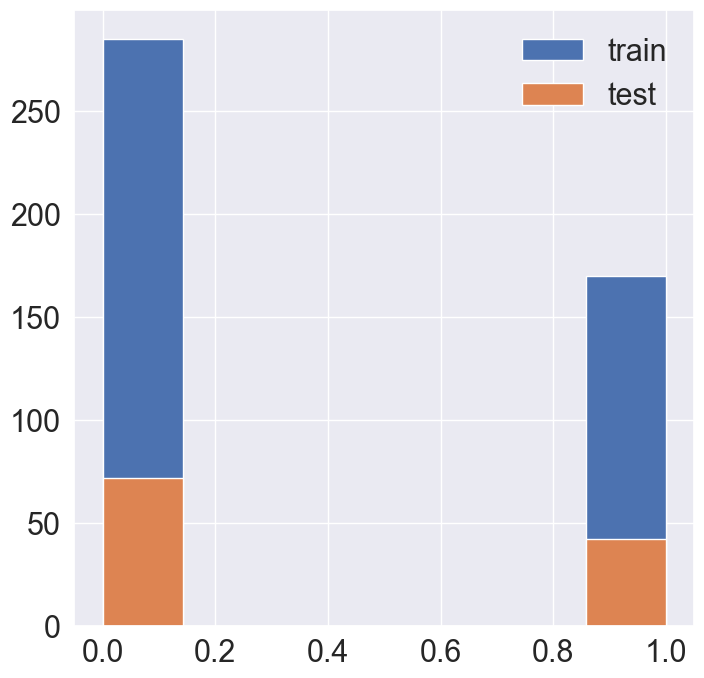

In [9]:
y_train.hist(bins=7, figsize=(8,8), label='train');
y_test.hist(bins=7, figsize=(8,8), label='test');
plt.legend();
# sauvegarderImage("La separation des données pour l'apprentissage")

# Le déclaration des classifieurs 

In [10]:
names = [
            'Random_Forest',
            'AdaBoost',
            'LogisticRegression',
            'Nearest_Neighbors',
            'Neural_Net'
        ]

classifiers = [
            RandomForestClassifier(
                max_depth=6,
                max_features=3,
                min_samples_split=4,
                n_estimators=12,
                n_jobs=-1
            ),
            AdaBoostClassifier(n_estimators=52),    
            LogisticRegression(
                C=0.81113,
                max_iter=8000,
                penalty='l2',
                solver='lbfgs',
                n_jobs=-1
            ),
            KNeighborsClassifier(
                algorithm='ball_tree',
                n_neighbors=24,
                p=1,
                weights='distance',
                n_jobs=-1
            ),
            MLPClassifier(alpha=1),
        ]

dictModels = {name:clf for name, clf in zip(names, classifiers)}

In [11]:
dictModels

{'Random_Forest': RandomForestClassifier(max_depth=6, max_features=3, min_samples_split=4,
                        n_estimators=12, n_jobs=-1),
 'AdaBoost': AdaBoostClassifier(n_estimators=52),
 'LogisticRegression': LogisticRegression(C=0.81113, max_iter=8000, n_jobs=-1),
 'Nearest_Neighbors': KNeighborsClassifier(algorithm='ball_tree', n_jobs=-1, n_neighbors=24, p=1,
                      weights='distance'),
 'Neural_Net': MLPClassifier(alpha=1)}

# Le choix des classifieurs 

In [12]:
def choixClassifieurs(X_train, y_train,X_test, y_test, dictModels):
    np.random.seed(123456)
    t0 = time.time()  
    # h = .02  # step size in the mesh
    lw = 1

    plt.figure(figsize=(18,36))
    if int(str(sns.__version__).split('.')[1]) > 8 : 
        plt.style.use('seaborn-v0_8-darkgrid')
    else:
        plt.style.use('seaborn-darkgrid')
    couleurs = sns.hls_palette(len(dictModels.keys()), l=.4, s=.9)
    r_acc,r_aucROC = dict(),dict()
    fauxPositifs, vraisPositifs, probabilites = dict(),dict(),dict()
    accuracy,logloss,hammingloss,precision,sensibilite,f1,jaccard = dict(),dict(),dict(),dict(),dict(),dict(),dict()
    prec, rec, tauxPR, avgPrecRec =  dict(),dict(),dict(),dict()

    for i, nom in enumerate(dictModels):    
        t1 = time.time()  
        dictModels[nom].fit(X_train, y_train)

        y_probas = dictModels[nom].predict_proba(X_test)
        y_pred = dictModels[nom].predict(X_test)
        fauxPositifs[nom], vraisPositifs[nom], probabilites[nom] = roc_curve(y_test.ravel(), y_probas[:, 1])

        r_aucROC[nom]     = auc(fauxPositifs[nom], vraisPositifs[nom])
        accuracy[nom]     = accuracy_score(y_test,y_pred)
        logloss[nom]      = log_loss(y_test,y_pred)
        hammingloss[nom]  = hamming_loss(y_test,y_pred)
        precision[nom]    = precision_score(y_test,y_pred)
        sensibilite[nom]  = recall_score(y_test,y_pred)
        f1[nom]           = f1_score(y_test,y_pred)
        jaccard[nom]      = jaccard_score(y_test,y_pred)


        prec[nom], rec[nom], tauxPR[nom] = precision_recall_curve(y_test.ravel(), y_probas[:, 1])
        avgPrecRec[nom] = average_precision_score(y_test.ravel(), y_probas[:, 1])

        print(f'{nom:21s}'+(' %.4f' % accuracy[nom]).lstrip('0'),end='\t--\t')
        print ("Area under the ROC curve : %0.4f" % r_aucROC[nom],end='\t--\t')
        print('Exécution  :'+('%.2fs' % (time.time() - t1)).lstrip('0'))

        plt.subplot(2, 1, 1)
        plt.plot(fauxPositifs[nom], vraisPositifs[nom], color=couleurs[i], label=nom + '(AUC = %0.4f)' % r_aucROC[nom])

        plt.subplot(2, 1, 2)
        plt.step(rec[nom], prec[nom], where='post', color=couleurs[i], label=f"{nom}(AP = {avgPrecRec[nom]:0.8f})")#alpha=0.8, 
        plt.fill_between(rec[nom], prec[nom], step='post', alpha=0.05)



    plt.subplot(2, 1, 1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Le taux de faux Positifs-(1 - Spécificité) = VN / (FP + VN)',size=18)
    plt.ylabel('Le taux de vrais positifs-Sensibilité = VP / (VP + FN)',size=18)
    plt.title('La courbe ROC (Receiver Operating Caracteristic)',size=20)
    plt.legend(loc="lower right")    

    plt.subplot(2, 1, 2)
    f_scores = np.linspace(0.2, 0.9, num=7)
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

    # plt.subplot(2, 1, 2)                
    # plt.plot([0, 1], [0.5, 0.5], 'k--')
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Sensibilité(Rappel) = VP / (VP + FN)', size=18)
    plt.ylabel('Précision = VP / (VP + FP)', size=18)      
    plt.title('La courbe Précision-Rappel',size=20)
    plt.legend(loc="lower left")    

    sauvegarderImage("Les courbes ROC et Précision-Rappel")    
    plt.show()

    print('Exécution  :'+('%.2fs' % (time.time() - t0)).lstrip('0'))

    resultat = pd.DataFrame(pd.Series(r_aucROC), columns=["aucROC"])
    resultat['avgPrecRec']     = pd.Series(avgPrecRec   )
    resultat['accuracy']     = pd.Series(accuracy   )
    resultat['f1']           = pd.Series(f1         )
    resultat['precision']    = pd.Series(precision  )
    resultat['sensibilite']  = pd.Series(sensibilite)
    resultat['logloss']      = pd.Series(logloss    )
    resultat['hammingloss']  = pd.Series(hammingloss)
    resultat['jaccard']      = pd.Series(jaccard    )

    resultat.sort_values('f1',ascending=False, inplace=True)
    return resultat

Random_Forest         0.9474	--	Area under the ROC curve : 0.9785	--	Exécution  :.16s
AdaBoost              0.9561	--	Area under the ROC curve : 0.9914	--	Exécution  :.37s
LogisticRegression    0.9561	--	Area under the ROC curve : 0.9937	--	Exécution  :2.82s
Nearest_Neighbors     0.9474	--	Area under the ROC curve : 0.9778	--	Exécution  :.09s
Neural_Net            0.9298	--	Area under the ROC curve : 0.9841	--	Exécution  :.48s


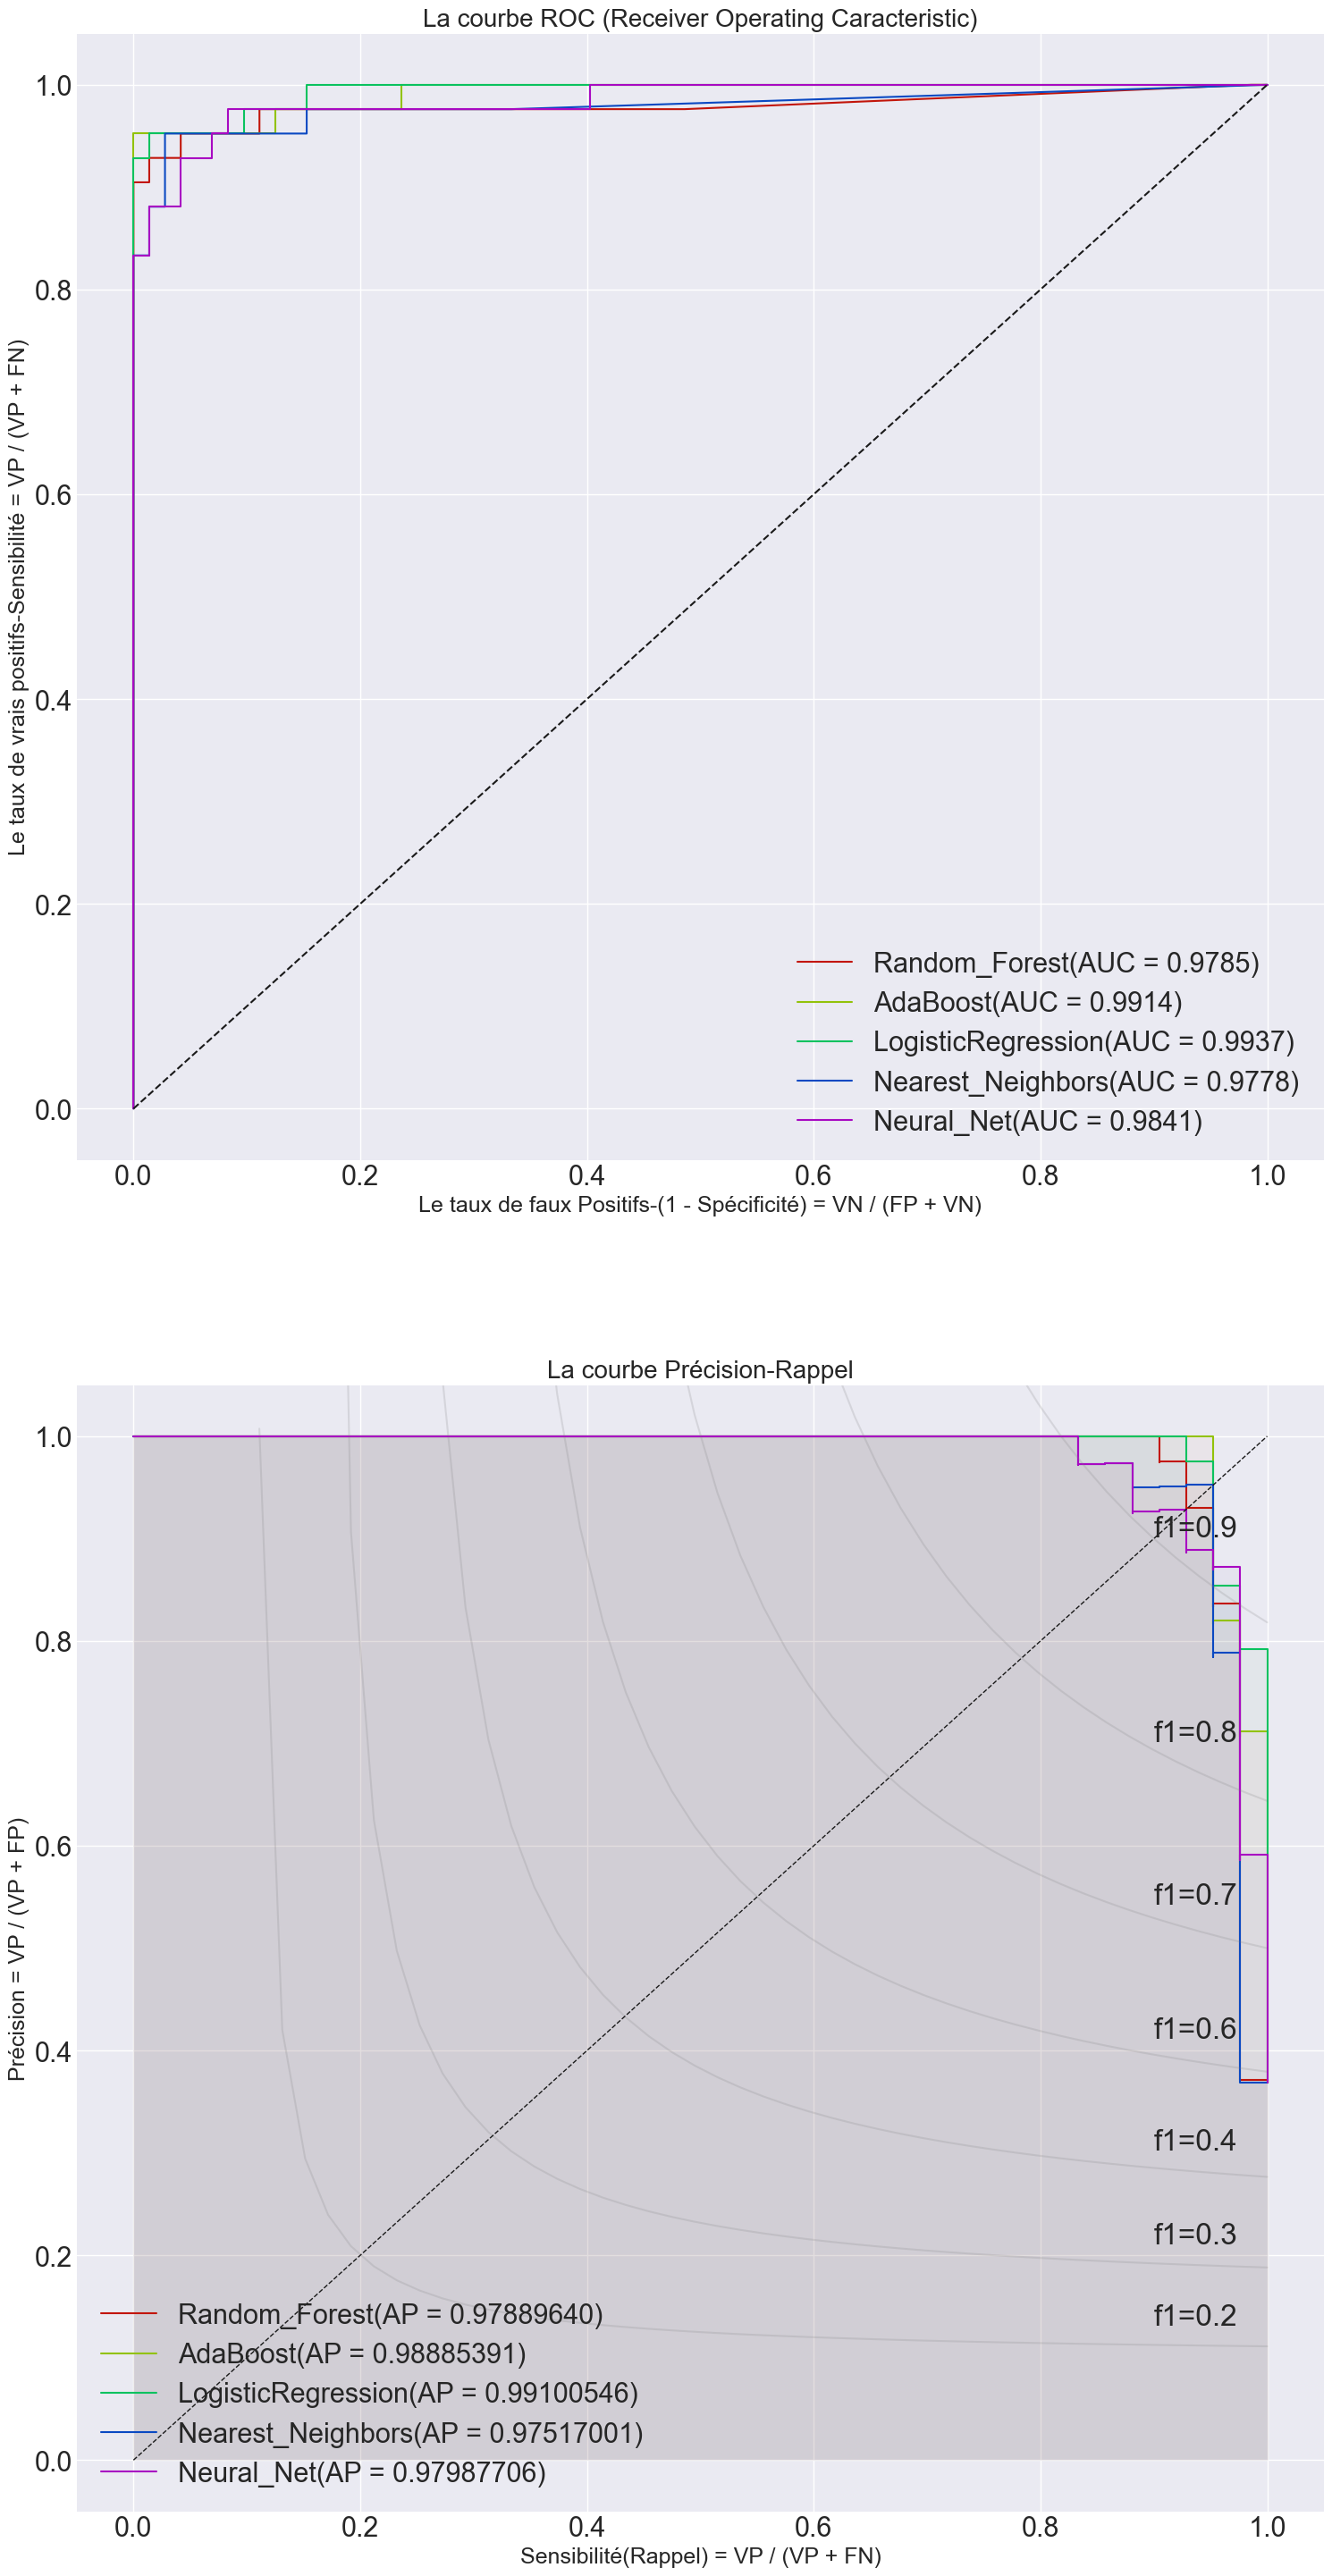

Exécution  :22.30s


In [13]:
resultatsBase = choixClassifieurs(X_train, y_train,X_test, y_test, dictModels)

In [14]:
resultatsBase['execution']='resultatsBase'
resultatsBase

,aucROC,avgPrecRec,accuracy,f1,precision,sensibilite,logloss,hammingloss,jaccard,execution
AdaBoost,0.991402,0.988854,0.956140,0.941176,0.930233,0.952381,1.580862,0.043860,0.888889,resultatsBase
LogisticRegression,0.993717,0.991005,0.956140,0.941176,0.930233,0.952381,1.580862,0.043860,0.888889,resultatsBase
Random_Forest,0.978505,0.978896,0.947368,0.930233,0.909091,0.952381,1.897034,0.052632,0.869565,resultatsBase
Nearest_Neighbors,0.977844,0.975170,0.947368,0.926829,0.950000,0.904762,1.897034,0.052632,0.863636,resultatsBase
Neural_Net,0.984127,0.979877,0.929825,0.906977,0.886364,0.928571,2.529379,0.070175,0.829787,resultatsBase
